# Methodology with CICIOT2025 Dataset

Steps:

1. Download original dataset from `https://www.unb.ca/cic/datasets/iiot-dataset-2025.html`.
2. Move datasets folder accordingly:
   * intellect/datasets/CICIOT25/attack_data
   * intellect/datasets/CICIOT25/benign_data
3. Install INTELLECT: `python3 -m pip install .` 
4. From the current folder, run `make CONFIG=config_iot.json all`
5. Once finished, continue with this notebook for visualizing results.

In [1]:
%reload_ext autoreload
%autoreload 2

import main as cmain
import pandas as pd
import numpy as np
from intellect.io import load
import matplotlib.pyplot as plt
from intellect.dataset import InputForLearn, ContinuouLearningAlgorithm, FeatureAvailability
from matplotlib.legend_handler import HandlerTuple

plt.rcParams.update({'text.usetex' : True,
          'font.size': 16,
          "font.family": "sans-serif",
          "font.sans-serif": "Helvetica",
          'figure.figsize': (6.4,4)})
plt.rc('text.latex', preamble=r"\usepackage{xcolor}")

We load the configuration and the dataset used.

In [2]:
# parameters

MIN_ACC = 0.5
CONFIG_PATH = "./config_iot.json"
config = cmain.Config(**load(CONFIG_PATH))
DEFAULT_SEED = config.seeds[0] # 42

train, validation, test = config.get_dataset(seed=DEFAULT_SEED)
unified = train.join(validation).join(test)

# Correlations Output

Display the traffic distribution with a pie chart so that we visualize attacks and distributions.

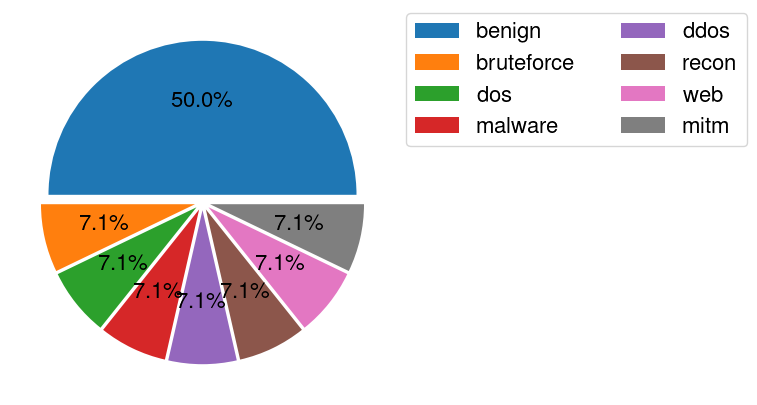

In [55]:
v = unified._y.value_counts()
v_perc = {k: f"{k} ({v})" for k, v in (unified._y.value_counts(normalize=True) * 100).round(2).items()}
ax = v.plot.pie(legend=True, ylabel="", explode=(0.05,)*len(v), labeldistance=None, autopct='%1.1f%%', figsize=(20, 5))
ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left', ncol=2)
plt.savefig(f"{config.output_path}/correlations.pdf", bbox_inches="tight")
display(plt.gcf())
plt.close()

We leverage the **Jensen Shannon** distance to find similarities/differences between traffic distributions, for each combination of labels.

In [ ]:
result = pd.read_csv(f"{config.output_path}/seed_{DEFAULT_SEED}_output/jensenshannon_perfeature.csv", index_col=[0, 1])
it = ((k, v) for k, v in result.T.describe().loc["mean"].sort_values(ascending=False).items() if config.benign_labels[0] in k[0] or config.benign_labels[0] in k[1])
list(it)

[(('benign', 'malware'), 0.5240068865801876),
 (('benign', 'web'), 0.5185446971358744),
 (('benign', 'bruteforce'), 0.4779390933880664),
 (('benign', 'dos'), 0.44864694725847004),
 (('benign', 'ddos'), 0.447842707403398),
 (('benign', 'recon'), 0.4301810404693379),
 (('benign', 'mitm'), 0.39413559424861033)]

## Train results

We load achieved baselines for the original Oracle model, supposedly trained in a FederatedLearning way to learn as much as possible from all attack categories.

* `AllC` means the model has been tested against all categories (see that there are no columns empty)
* `FewC` means the model has been tested against only one client categories (empty columns for unknown attacks)

In [3]:
baselines = load(f"{config.output_path}/seed_{DEFAULT_SEED}_output/oracle_baselines.csv", index_col=[0])
baselines

,Global,benign,bruteforce,ddos,dos,malware,mitm,recon,web
"('AllC', 'Train')",0.952806,0.992000,0.885057,0.915948,0.963362,0.926724,0.964799,0.829023,0.910201
"('AllC', 'Validation')",0.956473,0.992000,0.897516,0.906832,0.984472,0.928571,0.953271,0.847826,0.928571
"('AllC', 'Test')",0.948692,0.984333,0.883450,0.916084,0.955711,0.930070,0.946387,0.864802,0.895105
"('FewC', 'Train')",0.952945,0.989943,NaN,0.915948,NaN,NaN,NaN,NaN,NaN
"('FewC', 'Validation')",0.947205,0.987578,NaN,0.906832,NaN,NaN,NaN,NaN,NaN
"('FewC', 'Test')",0.951049,0.986014,NaN,0.916084,NaN,NaN,NaN,NaN,NaN


And now we display train results (Accuracy and MSE Loss).

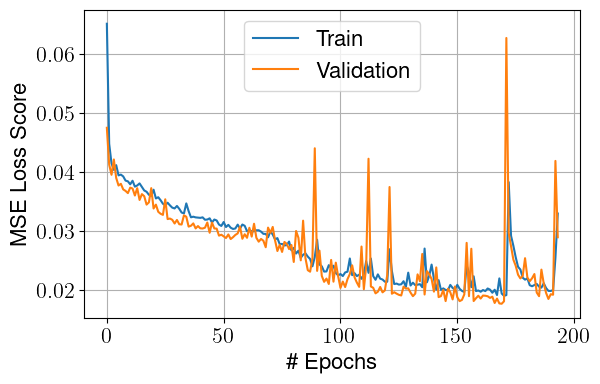

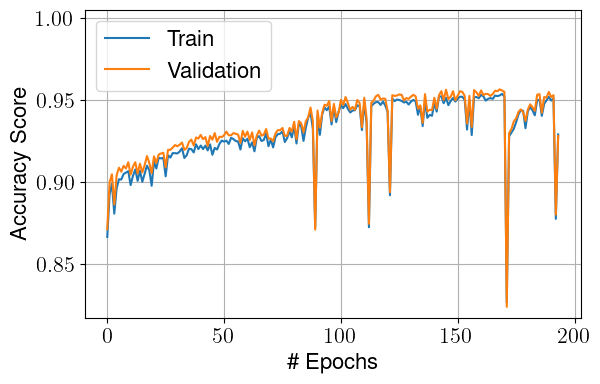

In [72]:
history_df = load(f"{config.output_path}/seed_{DEFAULT_SEED}_output/oracle_history.csv", index_col=0)
ax = history_df[["loss_train", "loss_validation"]].plot(ylabel="MSE Loss Score", xlabel="\# Epochs")
ax.legend(["Train", "Validation"])
ax.grid()
plt.savefig(f"{config.output_path}/seed_{DEFAULT_SEED}_output/train_loss.pdf", bbox_inches="tight")
display(plt.gcf())
plt.close()
ax = history_df[["accuracy_score_train", "accuracy_score_validation"]].plot(ylabel="Accuracy Score", xlabel="\# Epochs")
ax.legend(["Train", "Validation"])
ax.set_ylim(top=1.005)
ax.grid()
plt.savefig(f"{config.output_path}/seed_{DEFAULT_SEED}_output/train_acc.pdf", bbox_inches="tight")
display(plt.gcf())
plt.close()

## Rank and Prune

At this point, an organization X (us) has access to the Oracle model trained in the previous step (simulating FederatedLearning).

However, we may not be able to use this model in all our devices, due to their limited computational and memory capabilities.

For this reason, we want to undergo a phase of exploration, during which we aim at looking for the best subsets of features that preserve the model performance. At the same time, we also want to make to model a bit lighter and faster via pruning redundant or less influent neurons, to enable their deployment also in resource-constrained devices.

In this first step, we plot the outcome of a sequential feature elimination.

We compare different combination, during which we decide to:

1. either keep an initial ranking computed with the full subset, or to re-compute the feature importance as soon as we remove them;
2. remove 0-values first, or negative ones.

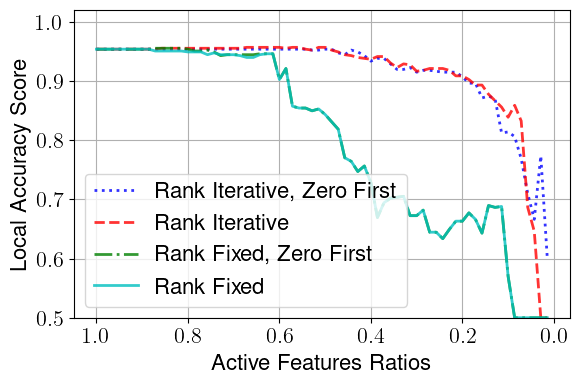

In [75]:
def plot_sequential_elimination_outcome(all_categories=False):
    new_df = pd.DataFrame()
    p = "all_c" if all_categories else "few_c"
    for p1 in ("iterative_rank", "fixed_rank"):
        for p2 in ("zero_first", "zero_not_first"):
            new_df[" ".join(x.capitalize() for x in p1.split("_")[::-1]) +
                   ("" if p2 == "zero_not_first" else ", " + " ".join(x.capitalize() for x in p2.split("_")))] = load(
                f"{config.output_path}/seed_{DEFAULT_SEED}_output/ranking/recursive_ss_{p}_{p1}_{p2}_scores.csv",
                index_col=0)["Global"]
    new_df.index = new_df.index / test.n_features
    ax = new_df.plot(alpha=0.8, style=['b:', 'r--', 'g-.', 'c-'], linewidth=2,
                     xlabel="Active Features Ratios", ylabel="Local Accuracy Score", figsize=(6.4, 4))
    ax.legend(loc="lower left")
    ax.set_ylim(bottom=MIN_ACC, top=1.02)
    ax.invert_xaxis()
    ax.grid()
    plt.savefig(f"{config.output_path}/seed_{DEFAULT_SEED}_output/recursive_ss_{p}.pdf", bbox_inches="tight")
    display(plt.gcf())
    plt.close()

plot_sequential_elimination_outcome()

Now we display the results of pruning the original Oracle model.
We use two different pruning techniques: Neurons and Connections.
For our methodology, we would continue with `Neurons`, as a `Connections`-based pruning would provide a sparse model. A sparse model could potentially mean no in-memory advantages, or even higher inference time.

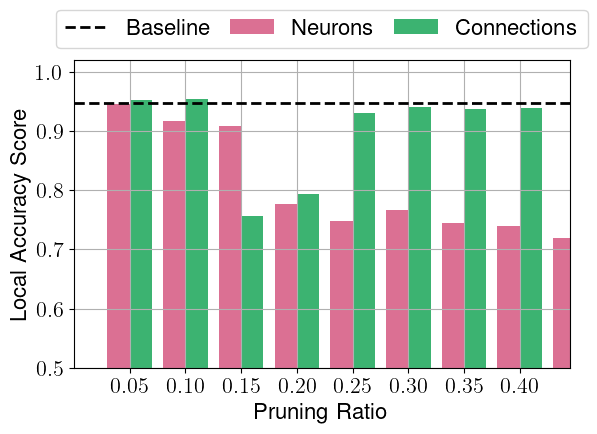

,Prune Ratio,Inference Time (ns),Memory (KB)
0,0.0,845.541012,332.015625
1,0.05,881.157642,296.265625
2,0.1,859.746134,270.765625
3,0.15,833.304704,246.390625
4,0.2,791.679489,223.140625
5,0.25,739.380712,201.015625
6,0.3,737.239774,173.265625
7,0.35,730.539108,153.765625
8,0.4,708.265644,135.390625
9,0.45,739.722561,118.140625


In [63]:
def pruning_only(all_categories=False):
    p = "all_c" if all_categories else "few_c"
    p_camelized = "".join(x.capitalize() for x in p.lower().split("_"))
    cols = ["Global"] if all_categories else config.client_categories
    ds = test if all_categories else test.filter_categories(config.client_categories)

    def get_size(n_input, n_hid_units, n_layers, data_size=8):
        coefs = data_size * ((n_input * n_hid_units) + (n_hid_units*n_hid_units*n_layers) + n_hid_units)
        intercepts = data_size * (n_hid_units*(n_layers+1)+1)
        return (coefs + intercepts)*2 / 1024

    v: pd.DataFrame = load(
        f"{config.output_path}/seed_{DEFAULT_SEED}_output/ranking/traffic_{p}_pruning_ratios_only_globally_neurons_l1.csv",
        index_col=0)
    v = v.sort_values(by="Prune Ratio")
    v2 = load(
        f"{config.output_path}/seed_{DEFAULT_SEED}_output/ranking/traffic_{p}_pruning_ratios_only_globally_unstructured_connections_l1.csv",
        index_col=0)
    v2 = v2.sort_values(by="Prune Ratio")

    vx: pd.DataFrame = v[cols].apply(lambda x: x.between(MIN_ACC, 1.)).all(axis=1)
    vx2: pd.DataFrame = v2[cols].apply(lambda x: x.between(MIN_ACC, 1.)).all(axis=1)
    v["Global"] *= 1*vx
    v2["Global"] *= 1*vx2
    v.rename(columns={"Prune Ratio": "Pruning Ratio", "Global": "Neurons"}, inplace=True)
    v2.rename(columns={"Prune Ratio": "Pruning Ratio", "Global": "Connections"}, inplace=True)
    last_index = max(vx[vx == True].index[-1], vx2[vx2 == True].index[-1])
    ax = v.plot.bar(x="Pruning Ratio", y="Neurons", ylabel="Local Accuracy Score",
                    legend=False, position=1, width=.4, rot=0., color="palevioletred")
    ax = v2.plot.bar(x="Pruning Ratio", y="Connections", ylabel="Local Accuracy Score", legend=False,
                     position=0, width=.4, ax=ax, rot=0., color="mediumseagreen")
    
    ax.set_xticklabels([f'$\\mathdefault{x:.2f}$' for x in v["Pruning Ratio"]])

    ax.set_ylim(bottom=MIN_ACC, top=1.02)
    ax.set_xlim(left=-1, right=7.9)
    ax.grid()
    ax.hlines(y=baselines.loc[f"('{p_camelized}', 'Validation')"]["Global"], xmin=-1, xmax=last_index+1,
              linestyles="dashed", linewidth=2, color='k', label="Baseline")
    ax.legend(loc="center", bbox_to_anchor=(0.5, 1.1), ncols=3,
              handler_map={tuple: HandlerTuple(ndivide=None)}, labelspacing=0., columnspacing=0.8)
    
    plt.savefig(f"{config.output_path}/seed_{DEFAULT_SEED}_output/pruning_only_{p}.pdf", bbox_inches="tight")
    display(plt.gcf())
    plt.close()
    
    m_normal = load(f"{config.output_path}/seed_{DEFAULT_SEED}_output/evaluation_full.json")
    v_normal = get_size(ds.n_features, config.n_hidden_units, config.n_hidden_layers)
    df = pd.DataFrame(columns=["Prune Ratio", "Inference Time (ns)", "Memory (KB)"])
    df.loc[len(df)] = ["0.0", np.mean(m_normal)/ds.n_samples, v_normal]

    amounts = v["Pruning Ratio"]
    
    for p in amounts:
        m_pruned = pd.Series(
            load(f"{config.output_path}/seed_{DEFAULT_SEED}_output/evaluation_pruned_{p}.json"))
        m_pruned = m_pruned[m_pruned.apply(lambda j: j >= m_pruned.quantile(.1) and j <= m_pruned.quantile(.75))]
        new_hidden_units = int(config.n_hidden_units * (1-p))
        v_pruned = get_size(ds.n_features, new_hidden_units, config.n_hidden_layers)
        df.loc[len(df)] = [f"{p}", np.mean(m_pruned)/ds.n_samples, v_pruned]
    df.to_latex(f"{config.output_path}/seed_{DEFAULT_SEED}_output/evaluation.tex",
                index=False, float_format="{:0.0f}".format)
    display(df)

pruning_only()

Now we use the original Oracle model and search for other possible subsets of features that could perform good.
This serves for two main reasons:
1. find out if there are other combinations that perform better than the "static" subsets achieved during the sequential feature removal (previous steps);
2. diversify the result: it is not said that all edge devices support the same subset of features, so we want to make sure to find other combinations that could be deployed too.

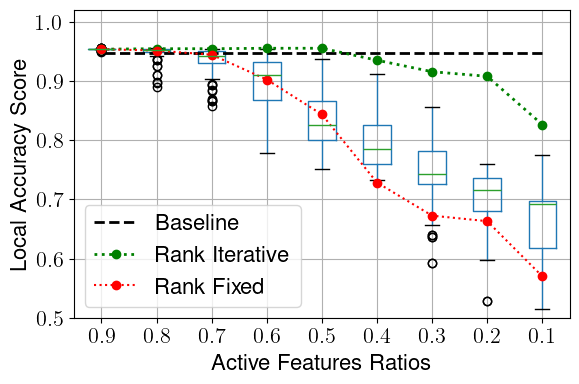

In [64]:
def plot_different_subsets_only_found(all_categories=False):
    p = "all_c" if all_categories else "few_c"
    p_camelized = "".join(x.capitalize() for x in p.lower().split("_"))

    tmp = {}
    cols = ["Global"] if all_categories else config.client_categories
    tmp = {
        round(x * validation.n_features):
        load(
            f"{config.output_path}/seed_{DEFAULT_SEED}_output/ranking/rank_{p}_traffic_{p}_subsetsize_{x}_scores.csv",
            index_col=0) for x in config.target_subset_ratios}
    for k, v in tmp.items():
        accepted: pd.DataFrame = v[v[cols].apply(lambda x: x.between(MIN_ACC, 1.)).all(axis=1)]
        tmp[k] = v.loc[accepted.index]
    asd = pd.DataFrame({k: v["Global"] for k, v in tmp.items()})
    ax, bp = asd.boxplot(ylabel="Local Accuracy Score", xlabel="Active Features Ratios", return_type='both', figsize=(6.4, 4))
    # Iterate over it!
    for fly in bp['fliers']:
        fdata = fly.get_data()
        tmp = []
        for x in fdata:
            if len(x) < 1:
                tmp.append([None, None])
                continue
            x = list(sorted(x))
            tmp.append(x[:5] + x[-5:])
        fly.set_data(tmp)
    ax.set_xticklabels([str(x) for x in config.target_subset_ratios])
    ax.hlines(y=baselines.loc[f"('{p_camelized}', 'Validation')"]["Global"], xmin=1, xmax=len(
        config.target_subset_ratios), linestyles="dashed", linewidth=2, color='k', label="Baseline")
    ax.set_ylim(bottom=0.5, top=1.02)
    ax.set_xticklabels([f'$\\mathdefault{x:.1f}$' for x in config.target_subset_ratios])
    ax.invert_xaxis()
    sz = [round(x*validation.n_features) for x in config.target_subset_ratios]
    b = load(
        f"{config.output_path}/seed_{DEFAULT_SEED}_output/ranking/recursive_ss_{p}_iterative_rank_zero_first_scores.csv",
        index_col=0).loc[sz, "Global"].reset_index(drop=True)
    b += load(f"{config.output_path}/seed_{DEFAULT_SEED}_output/ranking/recursive_ss_{p}_iterative_rank_zero_not_first_scores.csv",
              index_col=0).loc[sz, "Global"].reset_index(drop=True)
    b /= 2
    b.index += 1
    ax = b.plot(ax=ax, style="go:", label="Rank Iterative", grid=True, linewidth=2)
    b = load(
        f"{config.output_path}/seed_{DEFAULT_SEED}_output/ranking/recursive_ss_{p}_fixed_rank_zero_first_scores.csv",
        index_col=0).loc[sz, "Global"].reset_index(drop=True)
    b += load(f"{config.output_path}/seed_{DEFAULT_SEED}_output/ranking/recursive_ss_{p}_fixed_rank_zero_not_first_scores.csv",
              index_col=0).loc[sz, "Global"].reset_index(drop=True)
    b /= 2
    b.index += 1
    ax = b.plot(ax=ax, style="ro:", label="Rank Fixed", grid=True)
    ax.legend(loc="lower left")
    plt.savefig(f"{config.output_path}/seed_{DEFAULT_SEED}_output/subsets_only_{p}.pdf", bbox_inches="tight")
    display(plt.gcf())
    plt.close()


plot_different_subsets_only_found()

And to conclude this step, we do search for both (a) smaller subsets of features while also (b) pruning the original model.
We want to make sure that we increase the probability to find potential combinations of features that perform better on a pruned model.

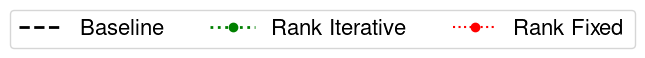

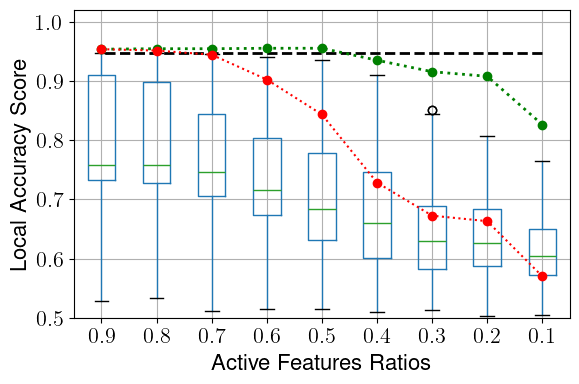

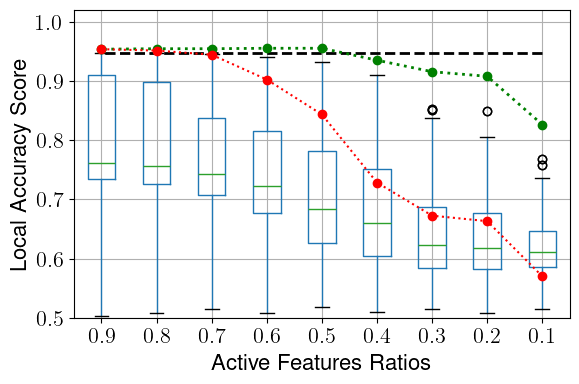

In [4]:
def plot_different_subsets_and_pruning(all_categories=False, prune_first=True, ax=None):
    show = ax is None 
    p = "all_c" if all_categories else "few_c"
    p_camelized = "".join(x.capitalize() for x in p.lower().split("_"))
    cols = ["Global"] if all_categories else config.client_categories
    tmp = {
        round(x * validation.n_features):
        load(
            f"{config.output_path}/seed_{DEFAULT_SEED}_output/ranking/rank_{p}_traffic_{p}_combo_pruned_models_subsetsize_{x}_{config.prune_method.__name__}_scores.csv"
            if prune_first else \
            f"{config.output_path}/seed_{DEFAULT_SEED}_output/ranking/rank_{p}_traffic_{p}_combo_subsetsize_{x}_pruned_models_{config.prune_method.__name__}_scores.csv"
            ,index_col=0) for x in config.target_subset_ratios}

    for k, v in tmp.items():
        accepted: pd.DataFrame = v[v[cols].apply(lambda x: x.between(MIN_ACC, 1.)).all(axis=1)]
        tmp[k] = v.loc[accepted.index]
    asd = pd.DataFrame({k: v["Global"] for k, v in tmp.items()})
    ax, bp = asd.boxplot(ylabel="Local Accuracy Score", xlabel="Active Features Ratios", return_type='both', figsize=(6.4, 4), ax=ax)
    for fly in bp['fliers']:
        fdata = fly.get_data()
        tmp2 = []
        for x in fdata:
            if len(x) < 1:
                tmp2.append([None, None])
                continue
            x = list(sorted(x))
            tmp2.append(x[:5] + x[-5:])
        fly.set_data(tmp2)
    ax.set_xticklabels([str(x) for x in config.target_subset_ratios])
    ax.hlines(y=baselines.loc[f"('{p_camelized}', 'Validation')"]["Global"], xmin=1, xmax=len(
        config.target_subset_ratios), linestyles="dashed", linewidth=2, color='k', label="Baseline")
    ax.set_ylim(bottom=MIN_ACC, top=1.02)
    ax.set_xticklabels([f'$\\mathdefault{x:.1f}$' for x in config.target_subset_ratios])
    ax.invert_xaxis()
    sz = [round(x*validation.n_features) for x in config.target_subset_ratios]
    b = load(
        f"{config.output_path}/seed_{DEFAULT_SEED}_output/ranking/recursive_ss_{p}_iterative_rank_zero_first_scores.csv",
        index_col=0).loc[sz, "Global"].reset_index(drop=True)
    b += load(f"{config.output_path}/seed_{DEFAULT_SEED}_output/ranking/recursive_ss_{p}_iterative_rank_zero_not_first_scores.csv",
              index_col=0).loc[sz, "Global"].reset_index(drop=True)
    b /= 2
    b.index += 1
    ax = b.plot(ax=ax, style="go:", label="Rank Iterative", grid=True, linewidth=2)
    b = load(
        f"{config.output_path}/seed_{DEFAULT_SEED}_output/ranking/recursive_ss_{p}_fixed_rank_zero_first_scores.csv",
        index_col=0).loc[sz, "Global"].reset_index(drop=True)
    b += load(f"{config.output_path}/seed_{DEFAULT_SEED}_output/ranking/recursive_ss_{p}_fixed_rank_zero_not_first_scores.csv",
              index_col=0).loc[sz, "Global"].reset_index(drop=True)
    b /= 2
    b.index += 1
    ax = b.plot(ax=ax, style="ro:", label="Rank Fixed", grid=True)

    ax.legend(loc="lower center", bbox_to_anchor=(0.5, 1.15), ncols=3,
              labelspacing=0., columnspacing=0.8, frameon=True)
    ax.get_legend().set_visible(show)
    return ax

fig, ax = plt.subplots()
fig2, ax2 = plt.subplots()

plot_different_subsets_and_pruning(prune_first=True, ax=ax)
plot_different_subsets_and_pruning(prune_first=False, ax=ax2);
handles, labels = ax2.get_legend_handles_labels()
f, o = plt.subplots()
o.set_visible(False)
f.legend(handles, labels, loc="center", bbox_to_anchor=(0.5, 1.1), ncols=len(handles))
f.savefig(f"{config.output_path}/seed_{DEFAULT_SEED}_output/legend.pdf", bbox_inches="tight")
fig.savefig(f"{config.output_path}/seed_{DEFAULT_SEED}_output/combo_prunefirst.pdf", bbox_inches="tight")
fig2.savefig(f"{config.output_path}/seed_{DEFAULT_SEED}_output/combo_subsetfirst.pdf", bbox_inches="tight")
display(f)
display(fig)
display(fig2)
plt.close(fig)
plt.close(fig2)
plt.close(f)

## Test

The training and search phase is finished. We now need to deploy the identitied model(s) to the devices to see their capability of recognizing attacks.

We want to remind that also in this phase the client does not have access to all labels (attacks), but only to a limited set (i.e., local traffic).

For this reason, we want to see if keeping training the resulting client models make performance worse, better, or preserves them.

Let's define a bunch of utilities.

In [62]:
def knowledge_loss_gain_score(df: pd.DataFrame, eval_after, eval_before, seen_categories=None,
                              func_weights: tuple[float] = None, ignore_categories: list[str] = None) -> pd.Series:
    """Function to measure with different indicators the knowledge loss/gain with respect to
    a baseline scenario, also provided in the dataframe.

    Args:
        df (pd.DataFrame): dataframe with data to be compared
        func_weights (tuple[float], optional): list of weights to assign to each
            indicator. Defaults to None.
        ignore_categories (list[str], Optinal): list of optional categories to exclude
            during the computation of the metrics. Default to None.

    Returns:
        pd.Series: a series containing all the indicators and the final evaluation function score.
    """
    if ignore_categories is None:
        ignore_categories = []
    df = df[df.columns.difference(ignore_categories + ['Global'])]

    if func_weights is None:
        func_weights = [0.25] * 4

    df = df[df.columns.difference(['Global'])]
    if seen_categories is None:
        seen_categories = df.columns.values

    seen = df[df.columns.intersection(seen_categories)].columns.values
    unseen = df[df.columns.difference(seen_categories)].columns.values

    seen_proportions = pd.Series([1/len(seen)]*len(seen), index=seen)
    if unseen.size:
        unseen_proportions = pd.Series([1/len(unseen)]*len(unseen), index=unseen)

    def f(after, before):
        diff = df.loc[after] - df.loc[before]
        diff_seen = diff[seen]
        diff_unseen = diff[unseen]

        loss_seen = diff_seen[diff_seen < 0]
        loss_seen = (loss_seen*seen_proportions).sum()
        gain_seen = diff_seen[diff_seen > 0]
        gain_seen = (gain_seen*seen_proportions).sum()

        loss_unseen = gain_unseen = 0
        if unseen.size:
            loss_unseen = diff_unseen[diff_unseen < 0]
            loss_unseen = (loss_unseen*unseen_proportions).sum()
            gain_unseen = diff_unseen[diff_unseen > 0]
            gain_unseen = (gain_unseen*unseen_proportions).sum()
        else:
            to_add = func_weights[2] / 2 + func_weights[3] / 2
            func_weights[2] = func_weights[3] = 0.
            func_weights[0] += to_add
            func_weights[1] += to_add

        factors = [loss_seen, gain_seen, loss_unseen, gain_unseen]

        return pd.Series([sum(factors[i] * func_weights[i] for i in range(len(factors)))] + factors,
                         index=['Func', 'Loss Seen', 'Gain Seen', 'Loss Unseen', 'Gain Unseen'])
    return f(eval_after, eval_before)

def get_name(scenario, availability, learn_input):
    base = config.output_path + f"/seed_{DEFAULT_SEED}_output/{scenario}"
    ret = {"HT": ContinuouLearningAlgorithm.ground_truth.name,
           "HD": ContinuouLearningAlgorithm.knowledge_distillation.name,
           "HI": ContinuouLearningAlgorithm.ground_inferred.name,
           "KD": ContinuouLearningAlgorithm.knowledge_distillation.name}
    for entry, alg in ret.items():
        extra = ""
        if alg == ContinuouLearningAlgorithm.knowledge_distillation.name:
            if entry == "HD":
                extra = "-learn_kwargs_{'alpha': 0.5}"
            else:
                extra = "-learn_kwargs_{'alpha': 1}"
        f_av_fixed = availability
        if alg == ContinuouLearningAlgorithm.ground_truth.name and (
                "_eo" in scenario or "_ec" in scenario) and learn_input.name == InputForLearn.client.name:
            f_av_fixed = FeatureAvailability.none
        ret[entry] = f"{base}/algorithm_{alg}-availability_{f_av_fixed.name}-learn_input_{learn_input.name}{extra}-max_epochs_{config.common_parameters['max_epochs']}-epochs_wo_improve_{config.common_parameters['epochs_wo_improve']}-batch_size_{config.batch_size}"
    return ret

def make_leg(savename, handles, labels, ncol=1):
    f, o = plt.subplots()
    o.set_visible(False)
    f.legend(handles, labels, loc="center", bbox_to_anchor=(0.5, 1.1), ncols=ncol, columnspacing=0.5, labelspacing=0., fontsize=18)
    f.savefig(f"{savename}-{ncol}.pdf", bbox_inches="tight")
    return f

def plot_thorugh_time_during_test_eval_metrics(cases, ax=None, ax2=None):
    show = False if ax is not None else True
    tmp2 = {}
    for name, pat in cases.items():
        f2 = load(pat + ".csv", index_col=0)
        f2.loc["Max Baseline"] = baselines.loc["('AllC', 'Test')"]
        tmp2[name] = f2.copy(deep=True)

    loss_before,loss_before_teach  = None, None
    for k, v in list(tmp2.items())[-1:]:
        loss_before = knowledge_loss_gain_score(
            v, "Test Before", "Max Baseline", seen_categories=config.client_categories if "few_c" in pat else None).abs()["Loss Unseen"]
        loss_before_teach = knowledge_loss_gain_score(
            v, "Oracle Test", "Max Baseline", seen_categories=config.client_categories if "few_c" in pat else None).abs()["Loss Unseen"]
        break

    asd2 = pd.DataFrame({k: v["Global"] for k, v in tmp2.items()}).T
    x = {
        k:
        knowledge_loss_gain_score(
            v, "Test After", "Max Baseline", seen_categories=config.client_categories if "few_c" in pat else None)
        for k, v in tmp2.items()}
    orac = asd2.pop("Oracle Test")
    bef = asd2.pop("Test Before")
    asd2.pop("Max Baseline")
    asd2.rename(columns={"Test After": "Score Student Fine-Tuned"}, inplace=True)
    ax = asd2.plot.bar(ylabel="Global Accuracy Score", xlabel="Learning Algorithms",
                       rot=0, position=1, legend=False, width=.3, ax=ax)
    ax2 = ax2 if ax2 is not None else ax.twinx()
    ajaj = pd.DataFrame(x).T["Loss Unseen"].abs()
    ajaj.rename(index="Loss Student Fine-Tuned", inplace=True)
    ajaj.plot.bar(ax=ax2, ylabel="Historical Accuracy Loss", xlabel="Learning Algorithms",
                  rot=0, position=0, legend=False, width=.3, color="darkorange")
    ax2.set_ylim(top=.52, bottom=-.01)
    ax2.hlines(y=loss_before_teach, xmin=-.6, xmax=3.5, linestyles='dashed', linewidth=3, color='maroon', label="Loss Teacher")
    ax2.hlines(y=loss_before, xmin=-.6, xmax=3.5, linestyles='dotted', linewidth=3, color='red', label="Loss Student")
    ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.])
    ax2.set_yticks([0., 0.1, 0.2, 0.3, 0.4, 0.5])
    for i, rect in enumerate(ax2.patches):
        height = rect.get_height()
        if height < MIN_ACC + 0.02:
            continue
        height = MIN_ACC + 0.01
        ax2.scatter(x=[i+0.15], y=[height], marker=10, c="k", s=40)

    ax.set_xlim(left=-.5, right=3.5)
    ax.set_ylim(top=1.02, bottom=MIN_ACC - 0.01)

    for xt in ax.get_xticks():
        ax.fill_between(x=[xt-.3,xt], y1=.4, y2=MIN_ACC, color="white")

    ax.hlines(y=bef.max(), xmin=-.6, xmax=3.5, linestyles='dashed', linewidth=3, color='teal', label="Score Student")
    ax.hlines(y=orac.max(), xmin=-.6, xmax=3.5, linestyles='dotted', linewidth=3, color='darkblue', label="Score Teacher")
    
    ax.plot(np.NaN, np.NaN, '-', color='none', label='a')
    ax.plot(np.NaN, np.NaN, '-', color='none', label='b')

    ax.grid(axis="y")
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines1 = lines1 + lines2
    labels1 = labels1 + labels2

    for_legend = {}
    for l, label in zip(lines1, labels1):
        if label.startswith("Loss") or label.startswith("Score"):
            for_legend[label] = l

    handles, labels = [], []
    for label in ["Score Teacher", "Score Student", "Score Student Fine-Tuned", "Loss Teacher", "Loss Student", "Loss Student Fine-Tuned"]:
        handles.append(for_legend[label])
        labels.append(label)

    ax.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, 1.), ncols=len(handles),
              handler_map={tuple: HandlerTuple(ndivide=None)}, labelspacing=0., columnspacing=0.8, frameon=True)
    ax.get_legend().set_visible(show)
    return handles, labels


def multiplot(performance_drop, subset_sizes, prune_ratios, o_to_what, take_third=False, save_axes=True):
    for i, (av, inp) in enumerate((
        (FeatureAvailability.none, InputForLearn.client),
        (FeatureAvailability.oracle, InputForLearn.client),
        (FeatureAvailability.oracle, InputForLearn.oracle),
        (FeatureAvailability.oracle, InputForLearn.mixed))):

        for j, subset_size in enumerate(subset_sizes):
            if o_to_what == "o_to_eo":
                fname = f"o_to_eo_few_c_performance_drop_{performance_drop}_subsetsize_{subset_size}"
            elif o_to_what == "o_to_ec_subset_then_prune":
                fname = f"o_to_ec_few_c_performance_drop_{performance_drop}_subsetsize_{subset_size}_prune_{prune_ratios[j]}"
            elif o_to_what == "o_to_ec_prune_then_subset":
                fname = f"o_to_ec_few_c_performance_drop_{performance_drop}_prune_{prune_ratios[j]}_subsetsize_{subset_size}"
            else:
                raise ValueError(f"Unknown o_to_what {o_to_what}")
                    
            tmp = fname.split("_")[-3] if take_third else fname.split("_")[-1]
            fig, ax = plt.subplots()
            twin = ax.twinx()
            handles, labels = plot_thorugh_time_during_test_eval_metrics(
                get_name(fname, av, inp), ax=ax, ax2=twin)
            if i == 0 and j == 0:
                f = make_leg(f"{config.output_path}/seed_{DEFAULT_SEED}_output/legend2", handles, labels, ncol=len(handles))
                display(f)
                plt.close(f)
            if save_axes:
                if j == 0:
                    twin.set_ylabel(twin.get_ylabel(), color="white")
                elif j+1 == len(subset_sizes):
                    ax.set_ylabel(ax.get_ylabel(), color="white")
                else:
                    ax.set_ylabel(ax.get_ylabel(), color="white")
                    twin.set_ylabel(twin.get_ylabel(), color="white")
            print(f"Test results for {o_to_what} scenario {performance_drop=} {prune_ratios=} {subset_size=} {inp=} {av=}")
            fig.savefig(f"{config.output_path}/seed_{DEFAULT_SEED}_output/{o_to_what}_case{i}_{tmp}_.pdf", bbox_inches="tight")
            display(fig)
            plt.close(fig)

We start with the following scenarios:

1. Oracle to Oracle: the "client" model is a copy of the Oracle. We suppose this device is able to handle the complete model and the entire original feature set.
2. Oracle to Pruned Oracle: the "client" model is a pruned version of the Oracle. We suppose the device has still access to the original feature set, but needs a lighter model.

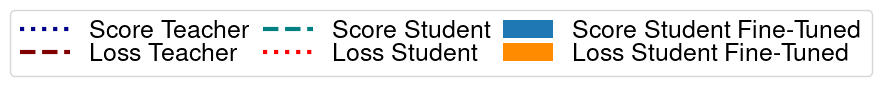

Test results for Oracle-to-Oracle scenario


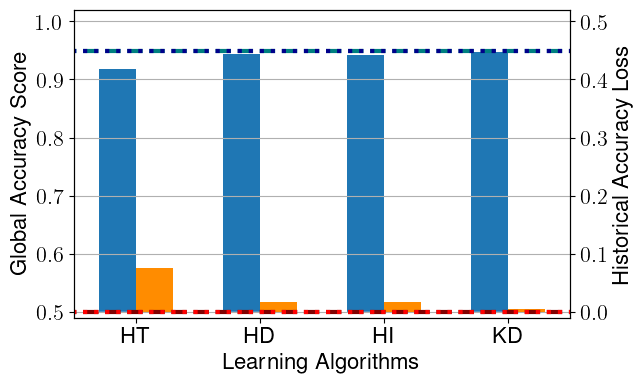

Test results for Oracle-to-Pruned-Oracle scenario PERFORMANCE_DROP=0.1 PRUNE_RATIO=0.15


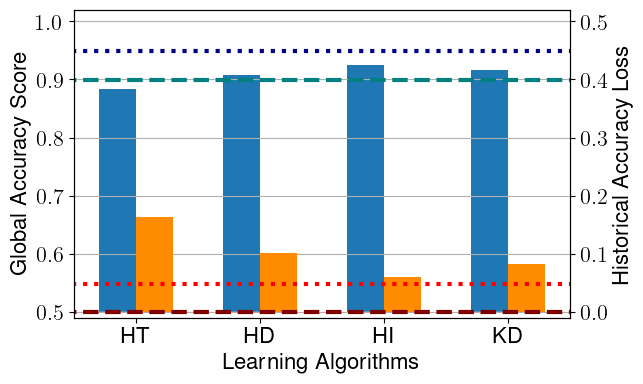

In [73]:
PERFORMANCE_DROP=0.1
PRUNE_RATIO=0.15

fig, axs = plt.subplots()
fig2, axs2 = plt.subplots()
plot_thorugh_time_during_test_eval_metrics(
    get_name("o_to_o_few_c", FeatureAvailability.bilateral, InputForLearn.client), ax=axs, ax2=axs.twinx());
handles, labels = plot_thorugh_time_during_test_eval_metrics(get_name(
    f"o_to_po_few_c_performance_drop_{PERFORMANCE_DROP}_prune_{PRUNE_RATIO}", FeatureAvailability.bilateral, InputForLearn.client), ax=axs2, ax2=axs2.twinx());
handles = [handles[0], handles[3], handles[1], handles[4], handles[2], handles[5]]
labels = [labels[0], labels[3], labels[1], labels[4], labels[2], labels[5]]
f = make_leg(f"{config.output_path}/seed_{DEFAULT_SEED}_output/legend2", handles, labels, ncol=3)
display(f)
plt.close(f)

print(f"Test results for Oracle-to-Oracle scenario")
fig.savefig(f"{config.output_path}/seed_{DEFAULT_SEED}_output/o_to_o.pdf", bbox_inches="tight")
display(fig)
plt.close(fig)

print(f"Test results for Oracle-to-Pruned-Oracle scenario {PERFORMANCE_DROP=} {PRUNE_RATIO=}")
fig2.savefig(f"{config.output_path}/seed_{DEFAULT_SEED}_output/o_to_po.pdf", bbox_inches="tight")
display(fig2)
plt.close(fig2)

Now we move to the Oracle-to-Edge-Oracle scenario. The "client" model is a copy of the original Oracle, but does not have access to the full original feature set.

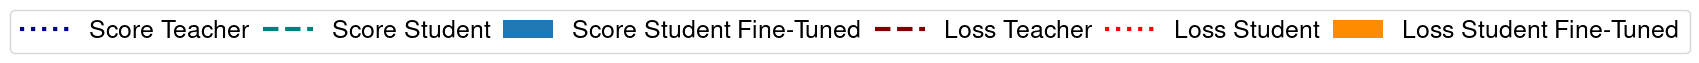

Test results for o_to_eo scenario performance_drop=0.1 prune_ratios=[] subset_size=0.4 inp=<InputForLearn.client: 0> av=<FeatureAvailability.none: 0>


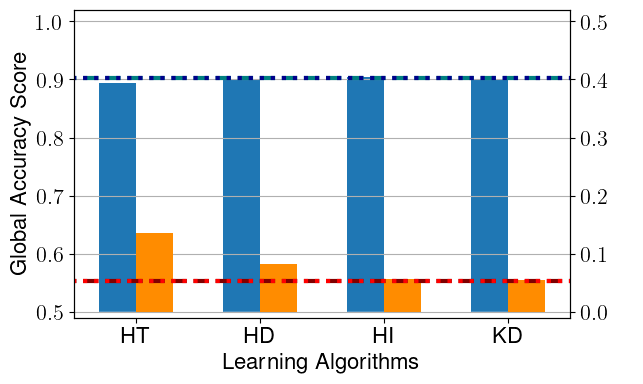

Test results for o_to_eo scenario performance_drop=0.1 prune_ratios=[] subset_size=0.6 inp=<InputForLearn.client: 0> av=<FeatureAvailability.none: 0>


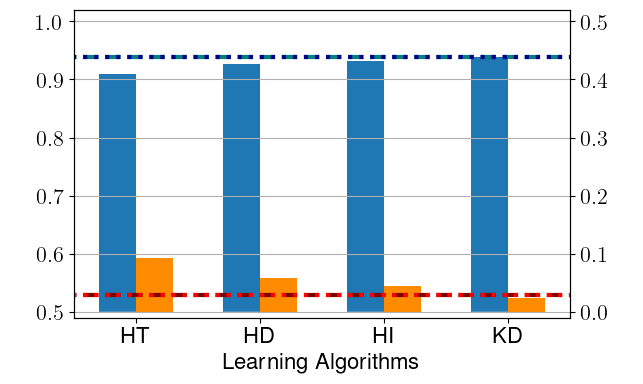

Test results for o_to_eo scenario performance_drop=0.1 prune_ratios=[] subset_size=0.8 inp=<InputForLearn.client: 0> av=<FeatureAvailability.none: 0>


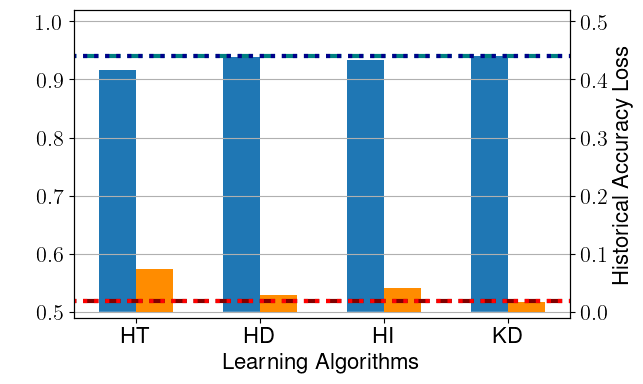

Test results for o_to_eo scenario performance_drop=0.1 prune_ratios=[] subset_size=0.4 inp=<InputForLearn.client: 0> av=<FeatureAvailability.oracle: 1>


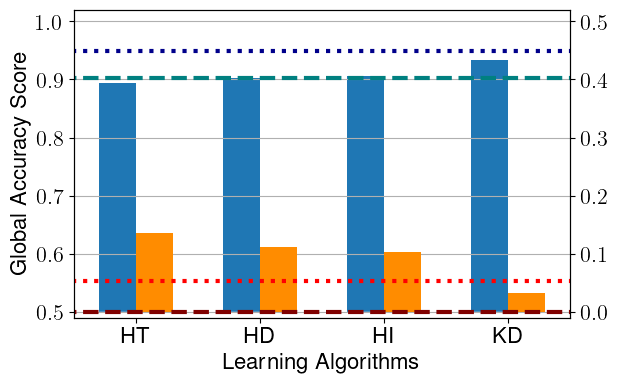

Test results for o_to_eo scenario performance_drop=0.1 prune_ratios=[] subset_size=0.6 inp=<InputForLearn.client: 0> av=<FeatureAvailability.oracle: 1>


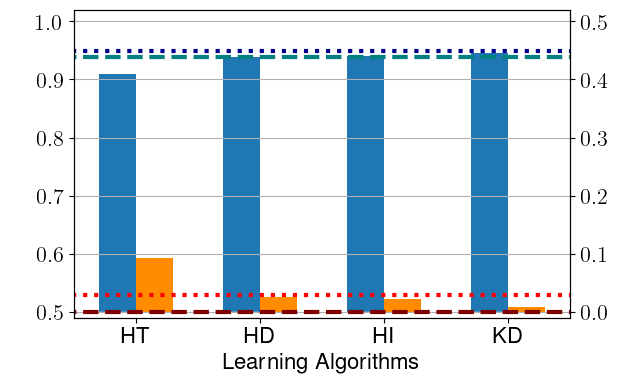

Test results for o_to_eo scenario performance_drop=0.1 prune_ratios=[] subset_size=0.8 inp=<InputForLearn.client: 0> av=<FeatureAvailability.oracle: 1>


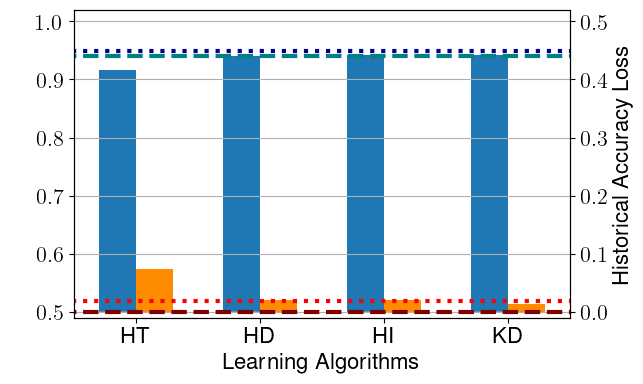

Test results for o_to_eo scenario performance_drop=0.1 prune_ratios=[] subset_size=0.4 inp=<InputForLearn.oracle: 1> av=<FeatureAvailability.oracle: 1>


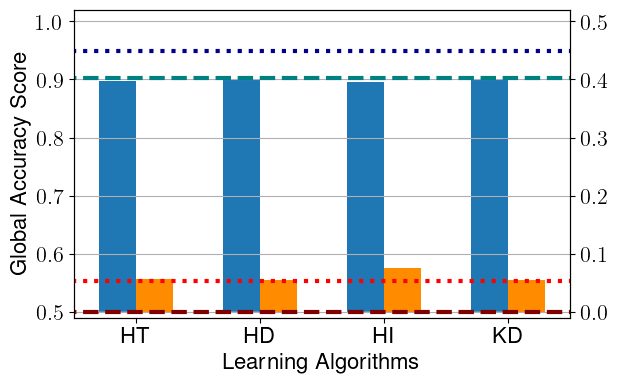

Test results for o_to_eo scenario performance_drop=0.1 prune_ratios=[] subset_size=0.6 inp=<InputForLearn.oracle: 1> av=<FeatureAvailability.oracle: 1>


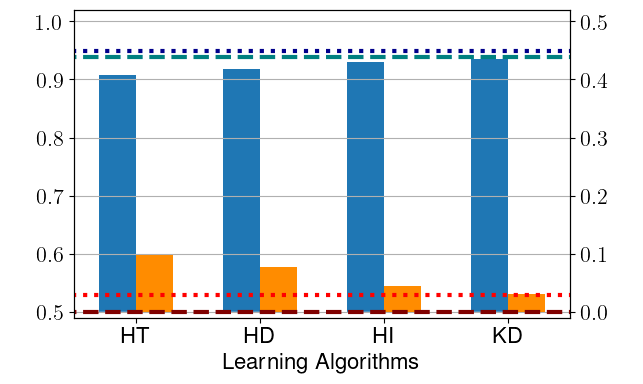

Test results for o_to_eo scenario performance_drop=0.1 prune_ratios=[] subset_size=0.8 inp=<InputForLearn.oracle: 1> av=<FeatureAvailability.oracle: 1>


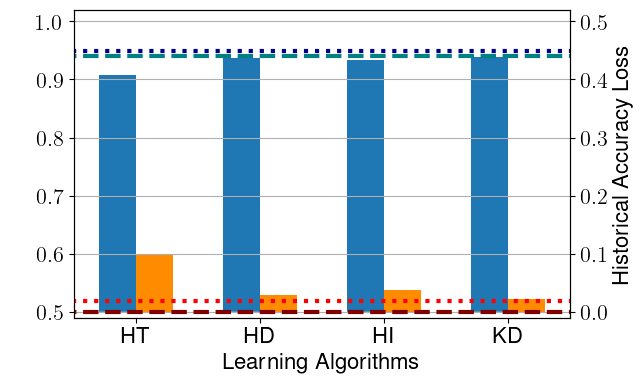

Test results for o_to_eo scenario performance_drop=0.1 prune_ratios=[] subset_size=0.4 inp=<InputForLearn.mixed: 2> av=<FeatureAvailability.oracle: 1>


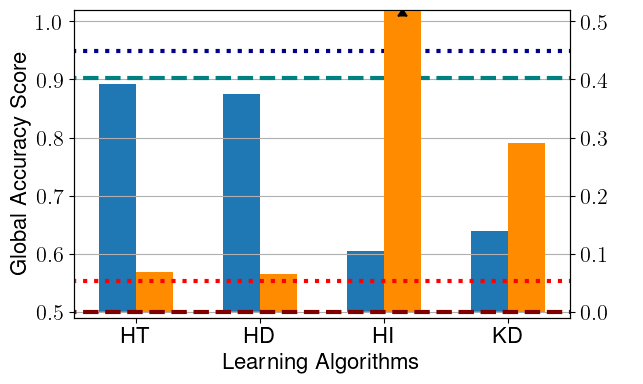

Test results for o_to_eo scenario performance_drop=0.1 prune_ratios=[] subset_size=0.6 inp=<InputForLearn.mixed: 2> av=<FeatureAvailability.oracle: 1>


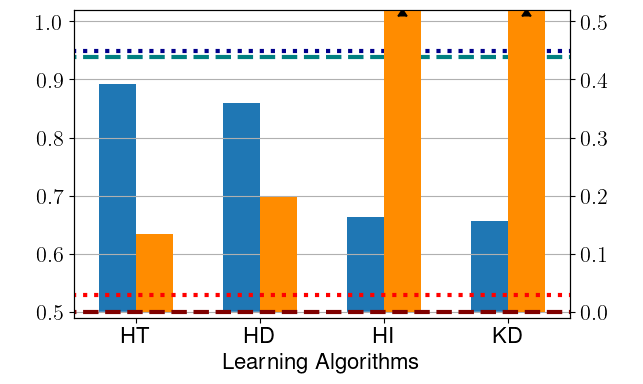

Test results for o_to_eo scenario performance_drop=0.1 prune_ratios=[] subset_size=0.8 inp=<InputForLearn.mixed: 2> av=<FeatureAvailability.oracle: 1>


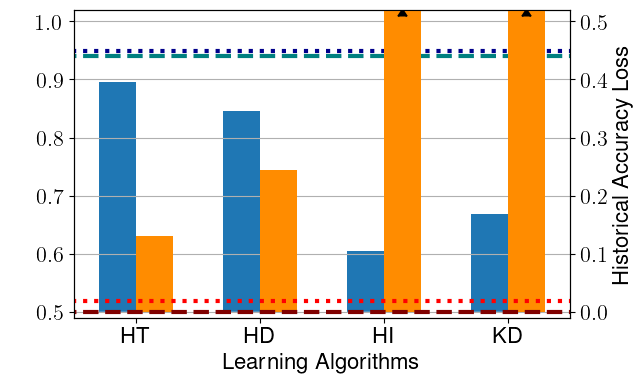

In [64]:
PERFORMANCE_DROP=0.1
SUBSET_SIZES=[0.4, 0.6, 0.8]
PRUNE_RATIOS=[]

multiplot(PERFORMANCE_DROP, SUBSET_SIZES, PRUNE_RATIOS, "o_to_eo", save_axes=True)

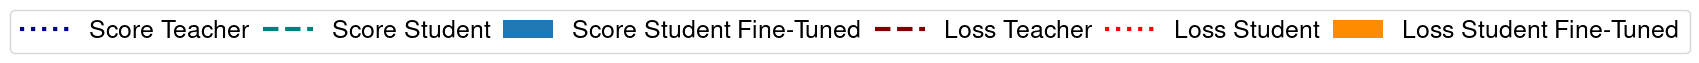

Test results for o_to_ec_prune_then_subset scenario performance_drop=0.2 prune_ratios=[0.2, 0.2, 0.15] subset_size=0.4 inp=<InputForLearn.client: 0> av=<FeatureAvailability.none: 0>


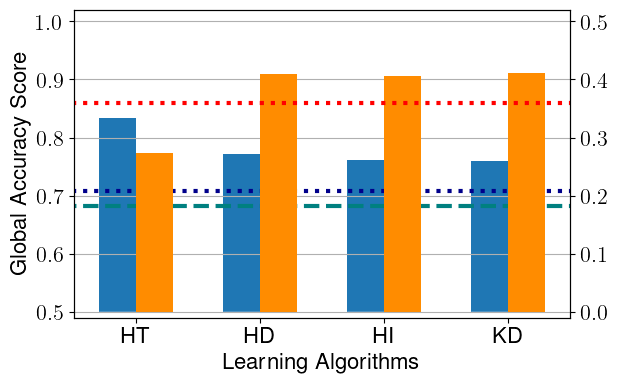

Test results for o_to_ec_prune_then_subset scenario performance_drop=0.2 prune_ratios=[0.2, 0.2, 0.15] subset_size=0.6 inp=<InputForLearn.client: 0> av=<FeatureAvailability.none: 0>


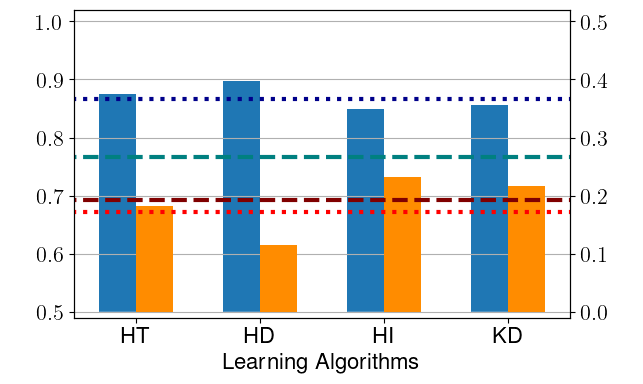

Test results for o_to_ec_prune_then_subset scenario performance_drop=0.2 prune_ratios=[0.2, 0.2, 0.15] subset_size=0.8 inp=<InputForLearn.client: 0> av=<FeatureAvailability.none: 0>


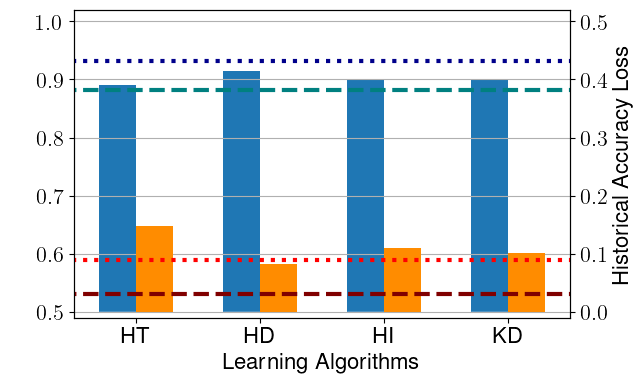

Test results for o_to_ec_prune_then_subset scenario performance_drop=0.2 prune_ratios=[0.2, 0.2, 0.15] subset_size=0.4 inp=<InputForLearn.client: 0> av=<FeatureAvailability.oracle: 1>


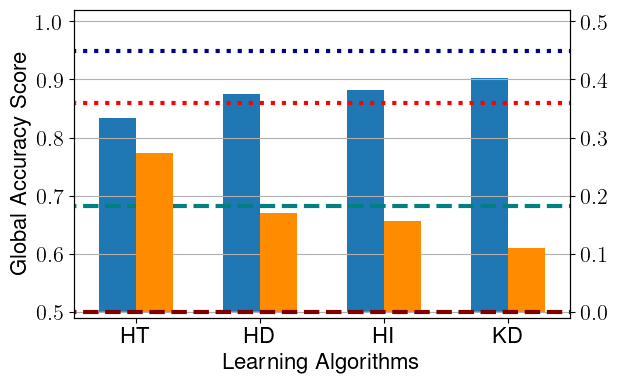

Test results for o_to_ec_prune_then_subset scenario performance_drop=0.2 prune_ratios=[0.2, 0.2, 0.15] subset_size=0.6 inp=<InputForLearn.client: 0> av=<FeatureAvailability.oracle: 1>


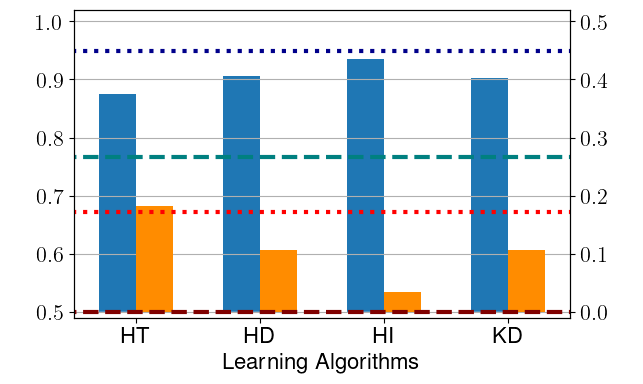

Test results for o_to_ec_prune_then_subset scenario performance_drop=0.2 prune_ratios=[0.2, 0.2, 0.15] subset_size=0.8 inp=<InputForLearn.client: 0> av=<FeatureAvailability.oracle: 1>


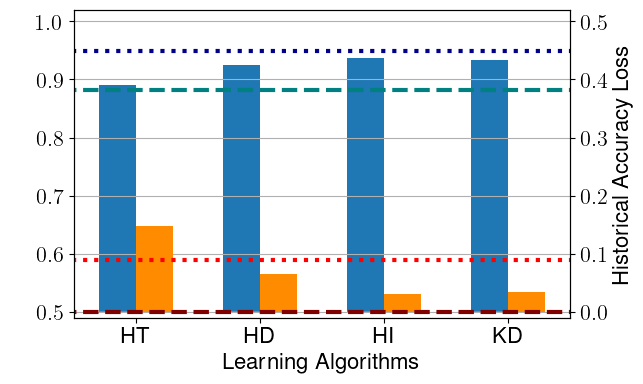

Test results for o_to_ec_prune_then_subset scenario performance_drop=0.2 prune_ratios=[0.2, 0.2, 0.15] subset_size=0.4 inp=<InputForLearn.oracle: 1> av=<FeatureAvailability.oracle: 1>


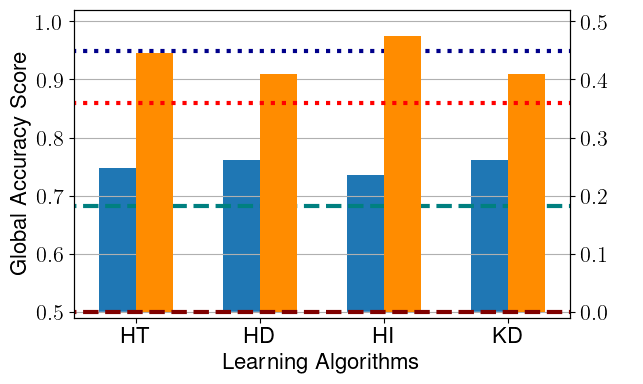

Test results for o_to_ec_prune_then_subset scenario performance_drop=0.2 prune_ratios=[0.2, 0.2, 0.15] subset_size=0.6 inp=<InputForLearn.oracle: 1> av=<FeatureAvailability.oracle: 1>


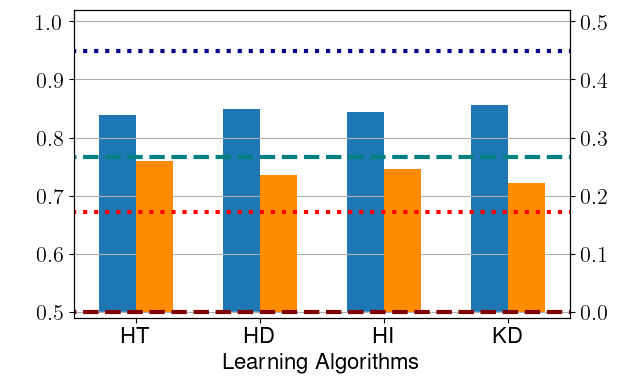

Test results for o_to_ec_prune_then_subset scenario performance_drop=0.2 prune_ratios=[0.2, 0.2, 0.15] subset_size=0.8 inp=<InputForLearn.oracle: 1> av=<FeatureAvailability.oracle: 1>


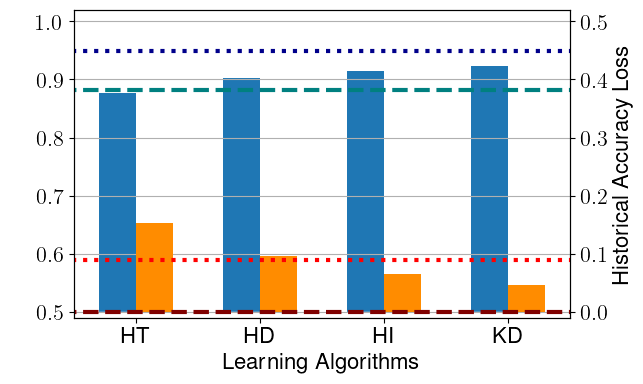

Test results for o_to_ec_prune_then_subset scenario performance_drop=0.2 prune_ratios=[0.2, 0.2, 0.15] subset_size=0.4 inp=<InputForLearn.mixed: 2> av=<FeatureAvailability.oracle: 1>


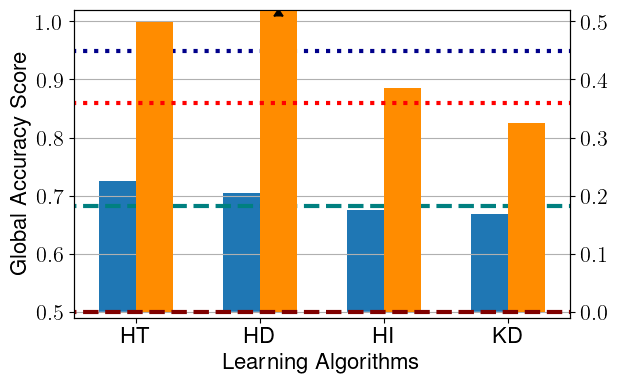

Test results for o_to_ec_prune_then_subset scenario performance_drop=0.2 prune_ratios=[0.2, 0.2, 0.15] subset_size=0.6 inp=<InputForLearn.mixed: 2> av=<FeatureAvailability.oracle: 1>


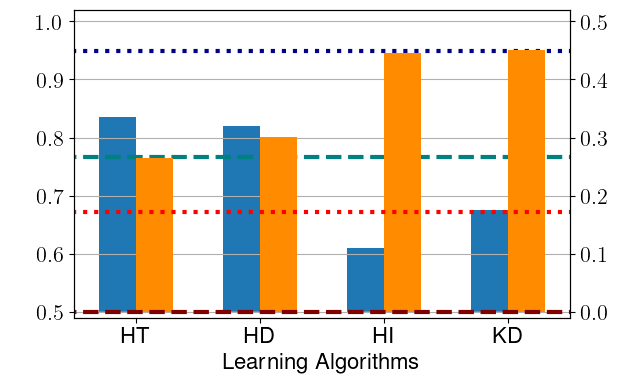

Test results for o_to_ec_prune_then_subset scenario performance_drop=0.2 prune_ratios=[0.2, 0.2, 0.15] subset_size=0.8 inp=<InputForLearn.mixed: 2> av=<FeatureAvailability.oracle: 1>


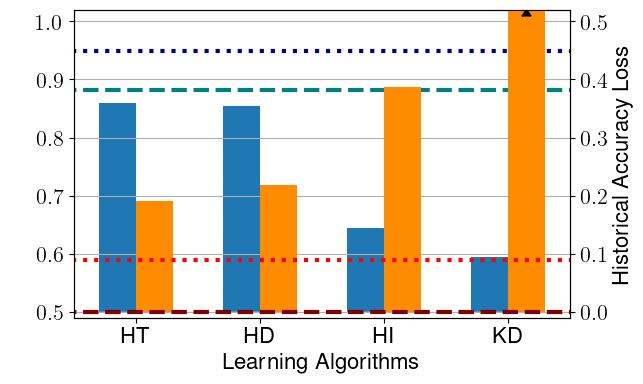

In [65]:
PERFORMANCE_DROP=0.2
PRUNE_RATIOS=[0.2,0.2,0.15]
SUBSET_SIZES=[0.4,0.6,0.8]

multiplot(PERFORMANCE_DROP, SUBSET_SIZES, PRUNE_RATIOS, "o_to_ec_prune_then_subset", save_axes=True)

## Convergence

Now we run a convergence analysis on each combination of case and algorithm.

We want to see the incremental Accuracy of the model on all the traffic categories, while being fine-tuned with only the local ones.

This should show us if the model incrementally lost information, was able to preserve them, or even improving.

In [57]:
def convergence(name, fav, inp, show_leg=False):
    cases = get_name(name, fav, inp)
    fig, axs = plt.subplots()
    axs2 = axs.twinx()
    data = {}
    data_loss = {}
    for name, pat in cases.items():
        f2: pd.DataFrame = load(pat + "_monitored.csv", index_col=0)
        f3: pd.DataFrame = load(pat + "_history.csv", index_col=0)
        data[name] = f2["Global"]
        data_loss[name] = f3["loss_train"]
    pd.DataFrame(data).plot(ylabel="Accuracy Score (historical)", xlabel="\# Epochs", ax=axs, ylim=(MIN_ACC-0.01, 1.02), style=['b', 'r', 'g', 'c'], linewidth=2, figsize=(6.4, 4), legend=False)
    pd.DataFrame(data_loss).plot(ylabel="Loss (local)", xlabel="\# Epochs", ax=axs2, style=['b', 'r', 'g', 'c'], linewidth=1, alpha=0.6, figsize=(6.4, 4), legend=False)
    
    if show_leg:
        lines1, labels1 = axs.get_legend_handles_labels()
        lines2, labels2 = axs2.get_legend_handles_labels()
        lines1 = lines1 + lines2
        labels1 = labels1 + labels2

        for_legend = {}
        for l, label in zip(lines1, labels1):
            if label not in for_legend:
                for_legend[label] = l

        handles, labels = list(for_legend.values()), list(for_legend.keys())
        f = make_leg(f"{config.output_path}/seed_{DEFAULT_SEED}_output/legend3", handles, labels, ncol=len(labels))
        display(f)
        plt.close(f)

    axs.grid(True, alpha=0.2)

    return fig, axs

We check the Oracle-to-Oracle and Oracle-to-Pruned-Oracle case, where all the features are still available.

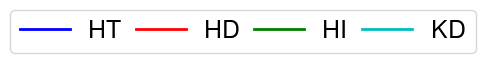

Test convergence for Oracle-to-Oracle scenario


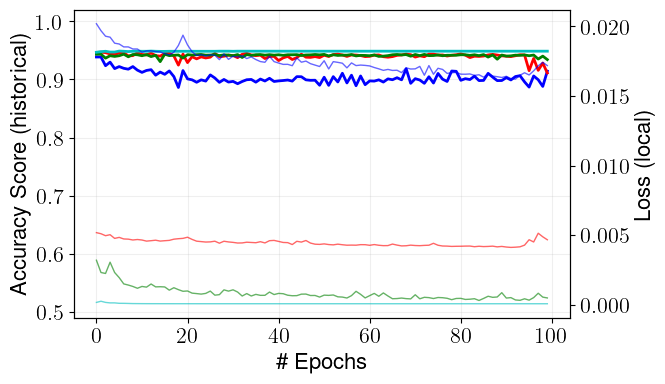

Test convergence for Oracle-to-Pruned-Oracle scenario


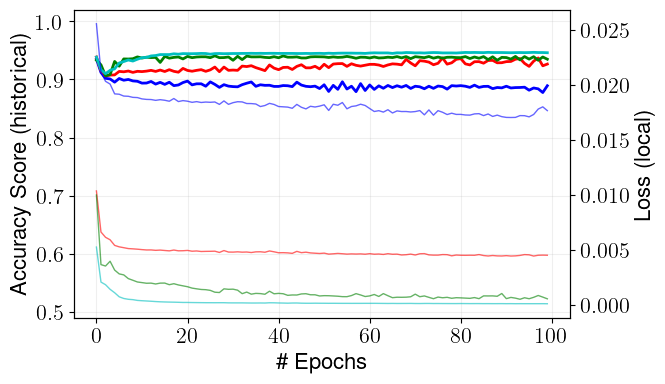

In [59]:
PERFORMANCE_DROP=0.1
PRUNE_RATIO=0.15

fig, axs = convergence("o_to_o_few_c", FeatureAvailability.bilateral, InputForLearn.client, show_leg=True);
print(f"Test convergence for Oracle-to-Oracle scenario")
fig.savefig(f"{config.output_path}/seed_{DEFAULT_SEED}_output/o_to_o_convergence.pdf", bbox_inches="tight")
display(fig)
plt.close(fig)

fig, axs = convergence(f"o_to_po_few_c_performance_drop_{PERFORMANCE_DROP}_prune_{PRUNE_RATIO}", FeatureAvailability.bilateral, InputForLearn.client);
print(f"Test convergence for Oracle-to-Pruned-Oracle scenario")
fig.savefig(f"{config.output_path}/seed_{DEFAULT_SEED}_output/o_to_po_convergence.pdf", bbox_inches="tight")
display(fig)
plt.close(fig)

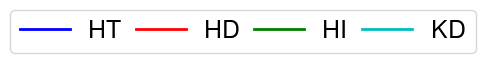

Test convergence for Oracle-to-Edge-Oracle scenario PERFORMANCE_DROP=0.1 subset_size=0.4 fav=<FeatureAvailability.none: 0> inp=<InputForLearn.client: 0>


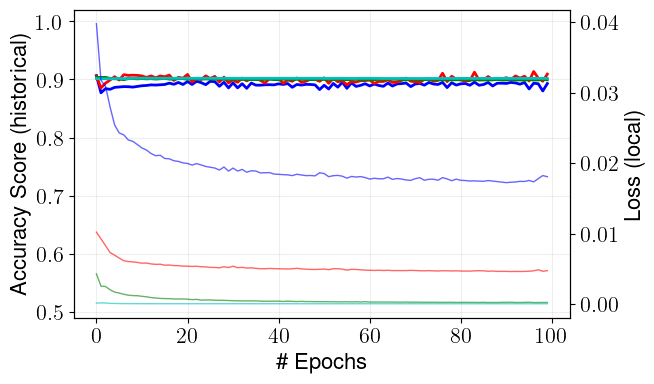

Test convergence for Oracle-to-Edge-Oracle scenario PERFORMANCE_DROP=0.1 subset_size=0.6 fav=<FeatureAvailability.none: 0> inp=<InputForLearn.client: 0>


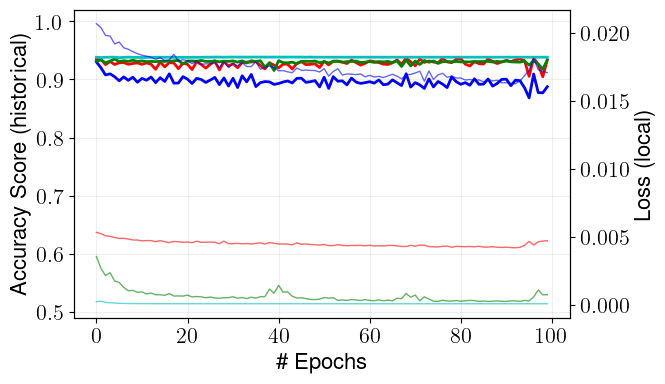

Test convergence for Oracle-to-Edge-Oracle scenario PERFORMANCE_DROP=0.1 subset_size=0.8 fav=<FeatureAvailability.none: 0> inp=<InputForLearn.client: 0>


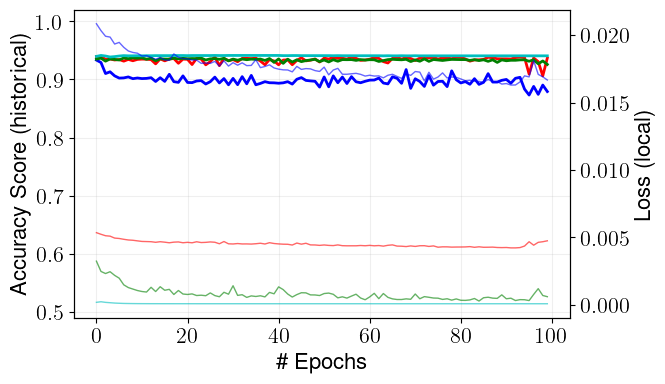

Test convergence for Oracle-to-Edge-Oracle scenario PERFORMANCE_DROP=0.1 subset_size=0.4 fav=<FeatureAvailability.oracle: 1> inp=<InputForLearn.client: 0>


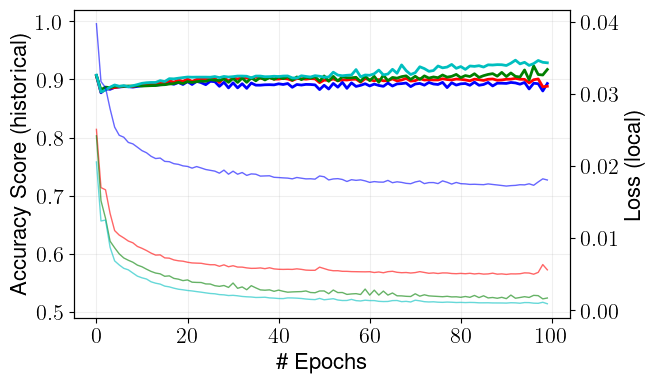

Test convergence for Oracle-to-Edge-Oracle scenario PERFORMANCE_DROP=0.1 subset_size=0.6 fav=<FeatureAvailability.oracle: 1> inp=<InputForLearn.client: 0>


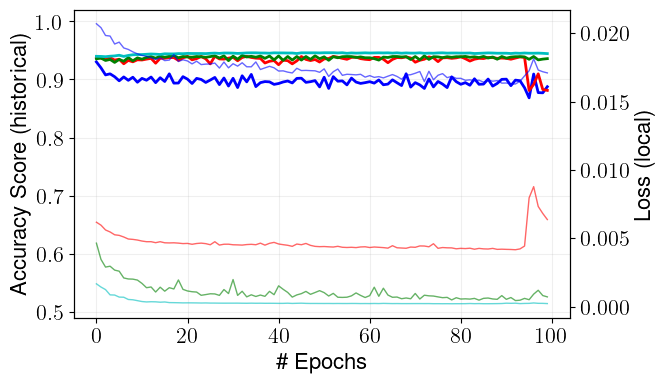

Test convergence for Oracle-to-Edge-Oracle scenario PERFORMANCE_DROP=0.1 subset_size=0.8 fav=<FeatureAvailability.oracle: 1> inp=<InputForLearn.client: 0>


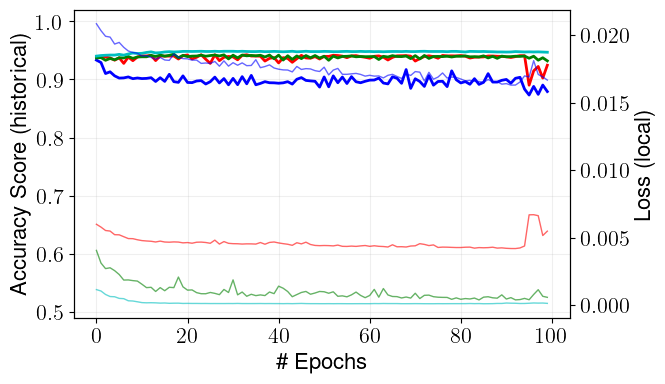

Test convergence for Oracle-to-Edge-Oracle scenario PERFORMANCE_DROP=0.1 subset_size=0.4 fav=<FeatureAvailability.oracle: 1> inp=<InputForLearn.oracle: 1>


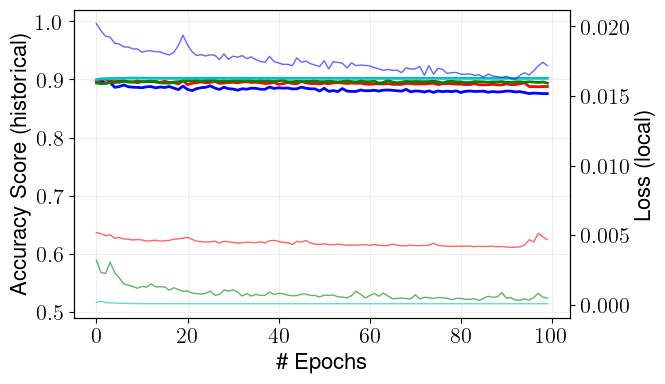

Test convergence for Oracle-to-Edge-Oracle scenario PERFORMANCE_DROP=0.1 subset_size=0.6 fav=<FeatureAvailability.oracle: 1> inp=<InputForLearn.oracle: 1>


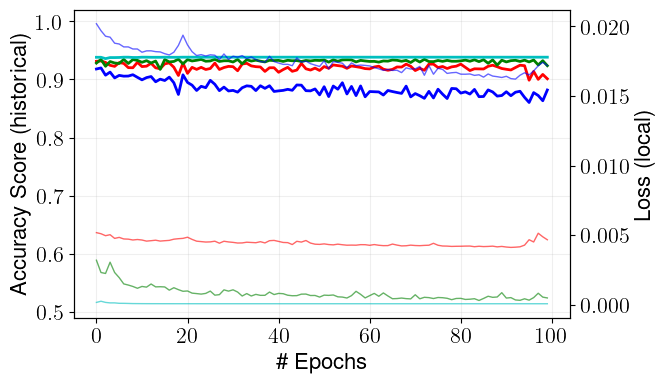

Test convergence for Oracle-to-Edge-Oracle scenario PERFORMANCE_DROP=0.1 subset_size=0.8 fav=<FeatureAvailability.oracle: 1> inp=<InputForLearn.oracle: 1>


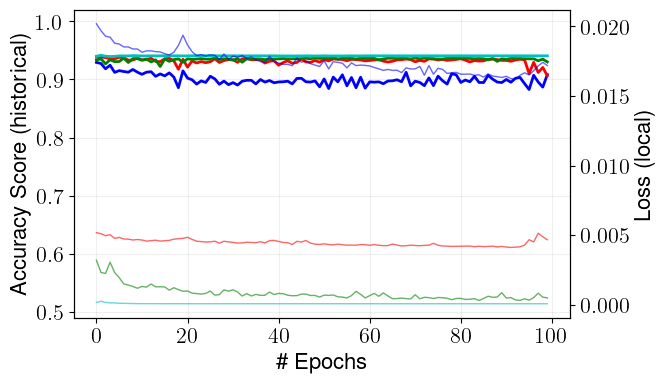

Test convergence for Oracle-to-Edge-Oracle scenario PERFORMANCE_DROP=0.1 subset_size=0.4 fav=<FeatureAvailability.oracle: 1> inp=<InputForLearn.mixed: 2>


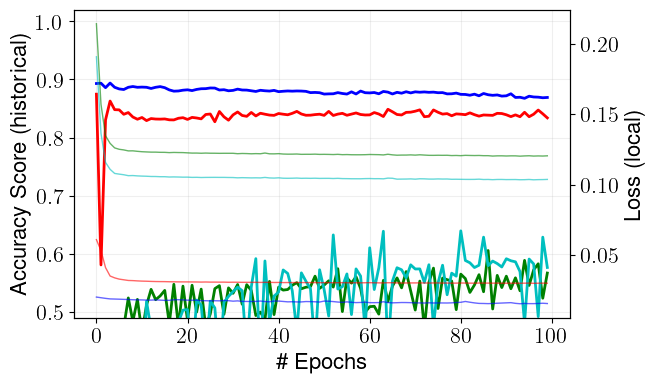

Test convergence for Oracle-to-Edge-Oracle scenario PERFORMANCE_DROP=0.1 subset_size=0.6 fav=<FeatureAvailability.oracle: 1> inp=<InputForLearn.mixed: 2>


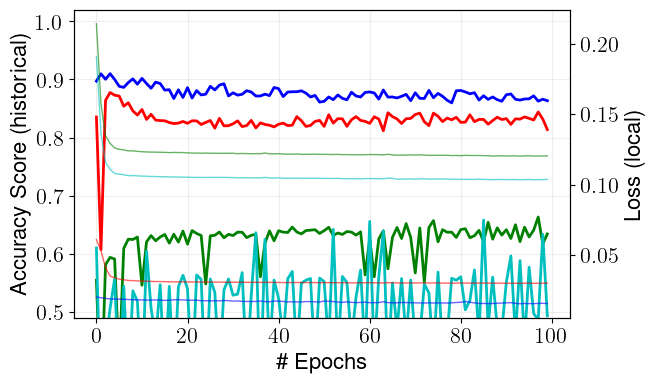

Test convergence for Oracle-to-Edge-Oracle scenario PERFORMANCE_DROP=0.1 subset_size=0.8 fav=<FeatureAvailability.oracle: 1> inp=<InputForLearn.mixed: 2>


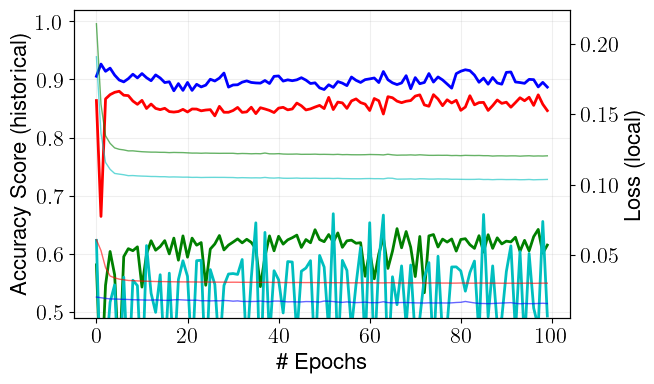

In [60]:
PERFORMANCE_DROP=0.1
PRUNE_RATIOS=[]
SUBSET_SIZES=[0.4,0.6,0.8]

for i, (fav, inp) in enumerate([(FeatureAvailability.none, InputForLearn.client),
        (FeatureAvailability.oracle, InputForLearn.client),
        (FeatureAvailability.oracle, InputForLearn.oracle),
        (FeatureAvailability.oracle, InputForLearn.mixed)]):
    for j, subset_size in enumerate(SUBSET_SIZES):
        fig, axs = convergence(f"o_to_eo_few_c_performance_drop_{PERFORMANCE_DROP}_subsetsize_{subset_size}", fav, inp, show_leg=(i==0 and j==0));
        fname = f"o_to_eo_few_c_performance_drop_{PERFORMANCE_DROP}_subsetsize_{subset_size}_case_{i}"
        
        print(f"Test convergence for Oracle-to-Edge-Oracle scenario {PERFORMANCE_DROP=} {subset_size=} {fav=} {inp=}")
        fig.savefig(f"{config.output_path}/seed_{DEFAULT_SEED}_output/{fname}_convergence.pdf", bbox_inches="tight")
        display(fig)
        plt.close(fig)

Test convergence for Oracle-to-Edge-Pruned-Oracle scenario PERFORMANCE_DROP=0.2 PRUNE_RATIO=0.2 subset_size=0.4 fav=<FeatureAvailability.none: 0> inp=<InputForLearn.client: 0>


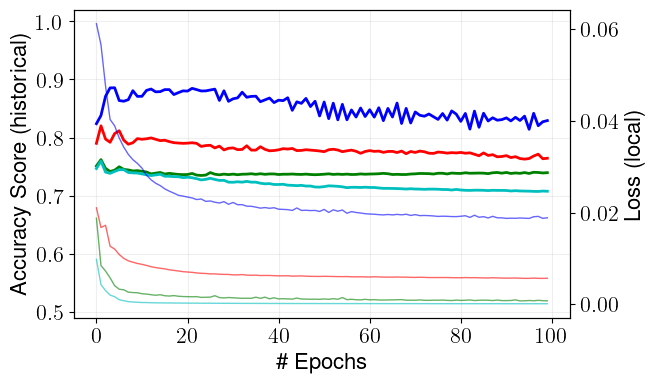

Test convergence for Oracle-to-Edge-Pruned-Oracle scenario PERFORMANCE_DROP=0.2 PRUNE_RATIO=0.2 subset_size=0.6 fav=<FeatureAvailability.none: 0> inp=<InputForLearn.client: 0>


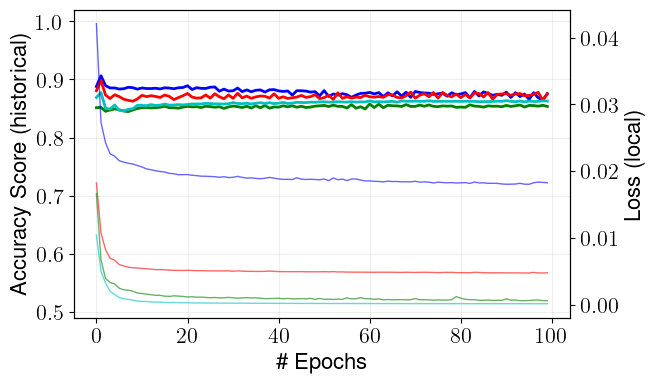

Test convergence for Oracle-to-Edge-Pruned-Oracle scenario PERFORMANCE_DROP=0.2 PRUNE_RATIO=0.15 subset_size=0.8 fav=<FeatureAvailability.none: 0> inp=<InputForLearn.client: 0>


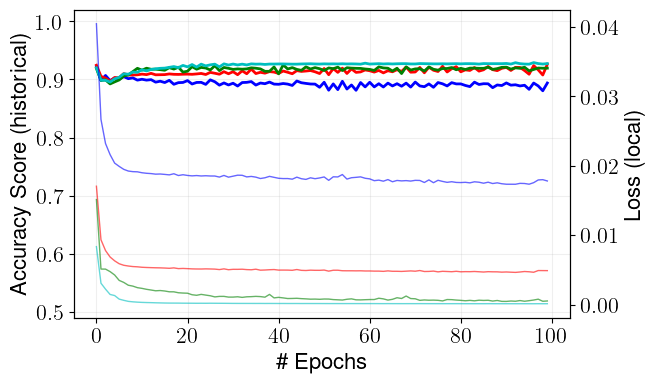

Test convergence for Oracle-to-Edge-Pruned-Oracle scenario PERFORMANCE_DROP=0.2 PRUNE_RATIO=0.2 subset_size=0.4 fav=<FeatureAvailability.oracle: 1> inp=<InputForLearn.client: 0>


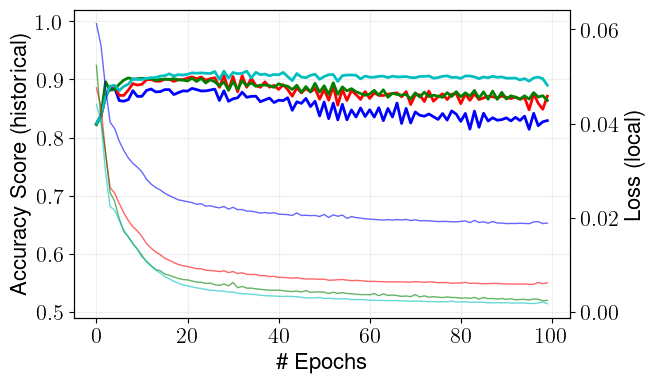

Test convergence for Oracle-to-Edge-Pruned-Oracle scenario PERFORMANCE_DROP=0.2 PRUNE_RATIO=0.2 subset_size=0.6 fav=<FeatureAvailability.oracle: 1> inp=<InputForLearn.client: 0>


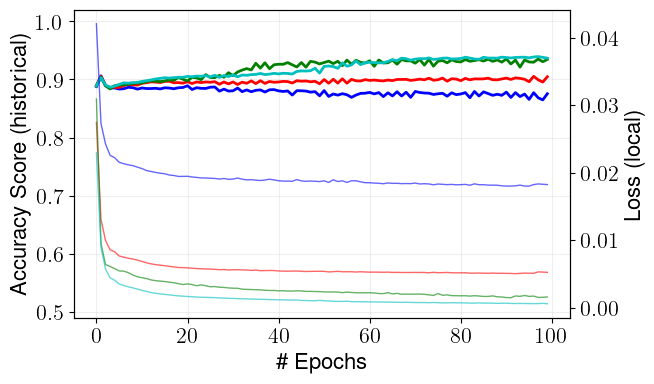

Test convergence for Oracle-to-Edge-Pruned-Oracle scenario PERFORMANCE_DROP=0.2 PRUNE_RATIO=0.15 subset_size=0.8 fav=<FeatureAvailability.oracle: 1> inp=<InputForLearn.client: 0>


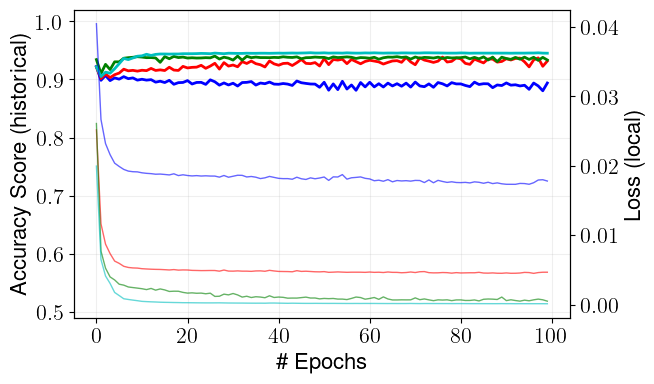

Test convergence for Oracle-to-Edge-Pruned-Oracle scenario PERFORMANCE_DROP=0.2 PRUNE_RATIO=0.2 subset_size=0.4 fav=<FeatureAvailability.oracle: 1> inp=<InputForLearn.oracle: 1>


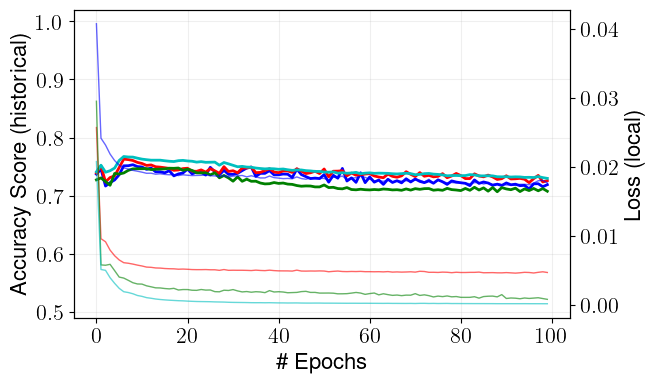

Test convergence for Oracle-to-Edge-Pruned-Oracle scenario PERFORMANCE_DROP=0.2 PRUNE_RATIO=0.2 subset_size=0.6 fav=<FeatureAvailability.oracle: 1> inp=<InputForLearn.oracle: 1>


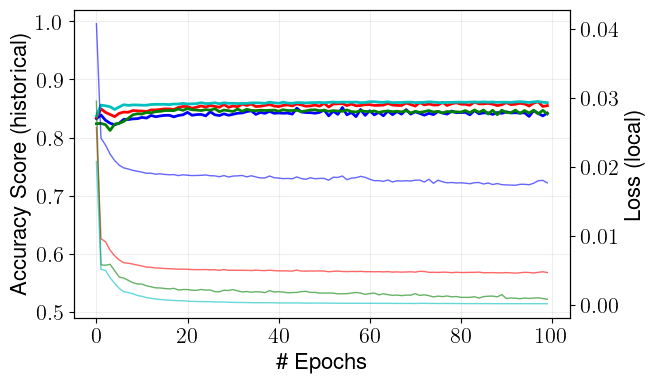

Test convergence for Oracle-to-Edge-Pruned-Oracle scenario PERFORMANCE_DROP=0.2 PRUNE_RATIO=0.15 subset_size=0.8 fav=<FeatureAvailability.oracle: 1> inp=<InputForLearn.oracle: 1>


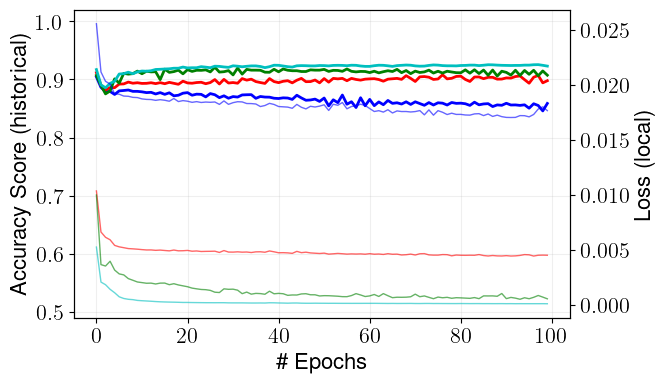

Test convergence for Oracle-to-Edge-Pruned-Oracle scenario PERFORMANCE_DROP=0.2 PRUNE_RATIO=0.2 subset_size=0.4 fav=<FeatureAvailability.oracle: 1> inp=<InputForLearn.mixed: 2>


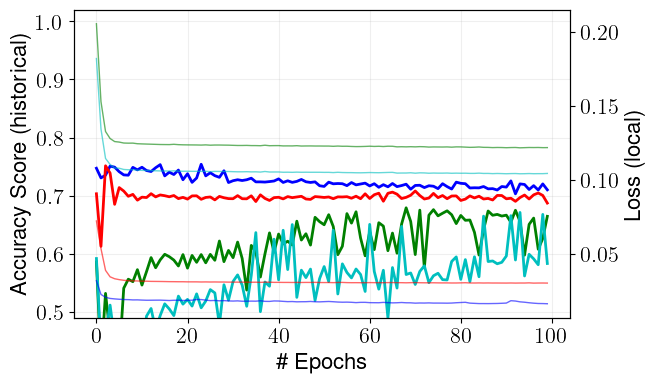

Test convergence for Oracle-to-Edge-Pruned-Oracle scenario PERFORMANCE_DROP=0.2 PRUNE_RATIO=0.2 subset_size=0.6 fav=<FeatureAvailability.oracle: 1> inp=<InputForLearn.mixed: 2>


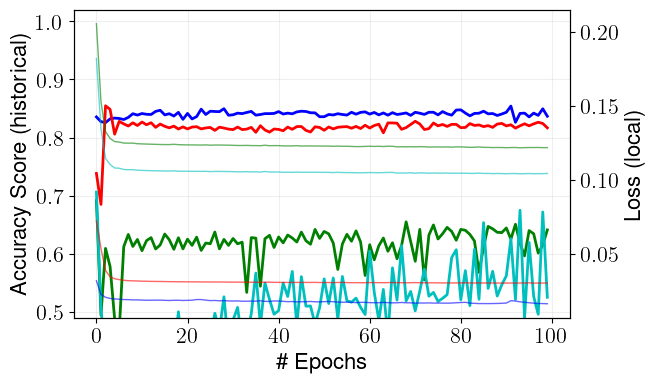

Test convergence for Oracle-to-Edge-Pruned-Oracle scenario PERFORMANCE_DROP=0.2 PRUNE_RATIO=0.15 subset_size=0.8 fav=<FeatureAvailability.oracle: 1> inp=<InputForLearn.mixed: 2>


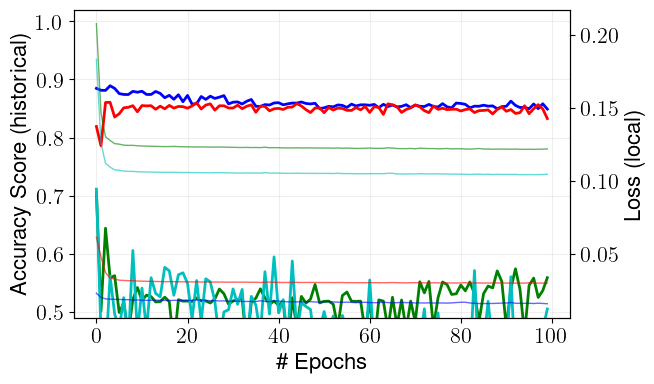

In [61]:
PERFORMANCE_DROP=0.2
PRUNE_RATIOS=[0.2,0.2,0.15]
SUBSET_SIZES=[0.4,0.6,0.8]

for i, (fav, inp) in enumerate([(FeatureAvailability.none, InputForLearn.client),
        (FeatureAvailability.oracle, InputForLearn.client),
        (FeatureAvailability.oracle, InputForLearn.oracle),
        (FeatureAvailability.oracle, InputForLearn.mixed)]):
    for j, subset_size in enumerate(SUBSET_SIZES):
        PRUNE_RATIO = PRUNE_RATIOS[j]
        fig, axs = convergence(f"o_to_ec_few_c_performance_drop_{PERFORMANCE_DROP}_prune_{PRUNE_RATIO}_subsetsize_{subset_size}", fav, inp);
        fname = f"o_to_ec_few_c_performance_drop_{PERFORMANCE_DROP}_prune_{PRUNE_RATIO}_subsetsize_{subset_size}_case_{i}"
        print(f"Test convergence for Oracle-to-Edge-Pruned-Oracle scenario {PERFORMANCE_DROP=} {PRUNE_RATIO=} {subset_size=} {fav=} {inp=}")
        fig.savefig(f"{config.output_path}/seed_{DEFAULT_SEED}_output/{fname}_convergence.pdf", bbox_inches="tight")
        display(fig)
        plt.close(fig)